In [76]:
##################################################
# Ref: https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions
###########################
# MBA Executivo em Economia e Gestão: Business Analytics e Big Data T3
# Alunos:
# André Ferreira Bem Silva
# Augusto Gonçalves
# Marcos Vinício Siqueira
# Fernando D'Imperio
###########################

from graphviz import Source
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from IPython.display import Image 
from IPython.display import SVG
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import os
import pandas as pd
import pydotplus 
import re
import seaborn as sns
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
class PathResolver:
    _relative_directory = '..'
    _source_directory = '{}/Src'.format(_relative_directory)
    _data_directory = '{}/Data'.format(_relative_directory)

    def GetDataFilepath(__self__, filename):
      return '{}/{}'.format(__self__._data_directory, filename)

    def GetSrcFilepath(__self__, filename):
      return '{}/{}'.format(__self__._source_directory, filename)

    def ReadDataFrameFromFilepath(__self__, filename):
      return pd.read_csv(__self__.GetDataFilepath(filename), sep=";")

In [3]:
path_resolver = PathResolver()

In [4]:
clients = path_resolver.ReadDataFrameFromFilepath('client.asc')
clients.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [5]:
class DateResolver:
    #Birthnumber is an abstraction that holds an encoded yymmdd in a specific format
    def resolve_gender_and_birthdate(__self__, date_number):
        [yy, mm, dd] = __self__._resolve_birthdate(date_number)
        
        return (__self__._resolve_gender_from_month(mm), __self__.get_date(yy, __self__._correct_month_if_necessary(mm), dd))
    
    def resolve_birthdate(__self__, date_number):
        [yy, mm, dd] = __self__._resolve_birthdate(date_number)
        
        return __self__.get_date(yy, __self__._correct_month_if_necessary(mm), dd)
    
    def _resolve_birthdate(__self__, date_number):
        pair_list = [int(x) for x in re.findall('\d{2}', str(date_number))]
        
        return [pair_list[0], pair_list[1], pair_list[2]]
        
    # If the month is larger than 50, then it is a woman (MM + 50)
    def _resolve_gender_from_month(__self__, mm):
        return 'Male' if mm < 50 else 'Female'
    
    def _correct_month_if_necessary(__self__, mm):
        return mm - 50 if mm >= 50 else mm
            
    def get_date(__self__, yy, mm, dd):
        return '19{}-{}-{}'.format(yy, mm, dd)

In [6]:
reference_analysis_date = pd.to_datetime("1999-09-15")

def get_int_years_delta(start_date, end_date):
    return len(pd.date_range(start = start_date, end = end_date,freq='D')) // 365

In [7]:
date_resolver = DateResolver()
genders_and_birth_dates = clients.birth_number.apply(date_resolver.resolve_gender_and_birthdate)
clients['gender'] = [gender for (gender, _) in genders_and_birth_dates]
clients['birth_date'] = [birth_date for (_, birth_date) in genders_and_birth_dates]
clients.birth_date = clients.birth_date.apply(pd.to_datetime)
clients['age'] = clients.birth_date.apply(lambda birth_date: get_int_years_delta(birth_date, reference_analysis_date))

clients.head()

,client_id,birth_number,district_id,gender,birth_date,age
0,1,706213,18,Female,1970-12-13,28
1,2,450204,1,Male,1945-02-04,54
2,3,406009,1,Female,1940-10-09,58
3,4,561201,5,Male,1956-12-01,42
4,5,605703,5,Female,1960-07-03,39


In [8]:
disposition = path_resolver.ReadDataFrameFromFilepath('disp.asc')
disposition.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT


In [9]:
districts = path_resolver.ReadDataFrameFromFilepath('district.asc')
districts.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [10]:
districts.columns = ['district_id','district_name','region',"n_inhabitants",
                    "municip_less_499","municip_between_500_1999","municip_between_2000_9999",
                    "municip_more_10000", "n_cities","ratio_urban_inhab","avg_salary","unemploy_rate_95",
                    "unemploy_rate_96","n_entrepreneurs_1000_inhab","n_commited_crimes_95","n_commited_crimes_96"]
districts.head()

,district_id,district_name,region,n_inhabitants,municip_less_499,municip_between_500_1999,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [11]:
clients_dispositions = pd.merge(clients, disposition, on = 'client_id')
clients_dispositions.head()

,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER
1,2,450204,1,Male,1945-02-04,54,2,2,OWNER
2,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT
3,4,561201,5,Male,1956-12-01,42,4,3,OWNER
4,5,605703,5,Female,1960-07-03,39,5,3,DISPONENT


In [12]:
credit_cards = path_resolver.ReadDataFrameFromFilepath('card.asc')
credit_cards.issued = pd.to_datetime(credit_cards.issued.apply(date_resolver.resolve_birthdate))
credit_cards.head()

,card_id,disp_id,type,issued
0,1005,9285,classic,1993-11-07
1,104,588,classic,1994-01-19
2,747,4915,classic,1994-02-05
3,70,439,classic,1994-02-08
4,577,3687,classic,1994-02-15


In [13]:
class CzechTranslator:    
    _cz_to_en_dict = {
        'POPLATEK MESICNE': 'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'after_transaction',
        'PRIJEM': 'credit', 'VYDAJ': 'debit', 'VYBER': 'choice',
        'VYBER KARTOU': 'card_debit', 'VKLAD': 'cash_credit', 'VYBER': 'cash_debit', 
        'PREVOD Z UCTU': 'other_bank_credit', 'PREVOD NA UCET': 'other_bank_debit',
        'POJISTNE': 'insurance', 'SIPO': 'household', 'LEASING': 'leasing', 'UVER': 'loan',
        'DUCHOD': 'pension', 'SLUZBY': 'statement_for_payment', 'SANKC. UROK': 'sanction_negative_balance', 'UROK': 'interest_credit'
    }
    
    def translate_if_possible(__self__, word):
        if type(word) != str:
            return ''
        
        uppercase_word = str.upper(word)
        
        return __self__._cz_to_en_dict[uppercase_word] if __self__._cz_to_en_dict.get(uppercase_word) != None else word
            
czech_to_en = CzechTranslator()

In [14]:
# Translates czech words
orders = path_resolver.ReadDataFrameFromFilepath('order.asc')
orders.k_symbol = orders.k_symbol.apply(czech_to_en.translate_if_possible)
orders.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,household
1,29402,2,ST,89597016,3372.7,loan
2,29403,2,QR,13943797,7266.0,household
3,29404,3,WX,83084338,1135.0,household
4,29405,3,CD,24485939,327.0,


In [15]:
# Translates A, B, C and D to human readable fields
loans_status_lookup = {'A': 'finished_ok', 'B': 'finished_with_default', 'C': 'running_ok', 'D': 'running_in_debt'}
loans = path_resolver.ReadDataFrameFromFilepath('loan.asc')
loans.date = pd.to_datetime(loans.date.apply(date_resolver.resolve_birthdate))
loans.status = [loans_status_lookup[status] for status in loans.status]
loans.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,finished_with_default
1,5316,1801,1993-07-11,165960,36,4610.0,finished_ok
2,6863,9188,1993-07-28,127080,60,2118.0,finished_ok
3,5325,1843,1993-08-03,105804,36,2939.0,finished_ok
4,7240,11013,1993-09-06,274740,60,4579.0,finished_ok


In [16]:
accounts = path_resolver.ReadDataFrameFromFilepath('account.asc')
accounts.date = pd.to_datetime(accounts.date.apply(date_resolver.resolve_birthdate))
accounts.frequency = accounts.frequency.apply(czech_to_en.translate_if_possible)
print(accounts.frequency.value_counts())
accounts.head()

monthly              4167
weekly                240
after_transaction      93
Name: frequency, dtype: int64


,account_id,district_id,frequency,date
0,576,55,monthly,1993-01-01
1,3818,74,monthly,1993-01-01
2,704,55,monthly,1993-01-01
3,2378,16,monthly,1993-01-01
4,2632,24,monthly,1993-01-02


In [17]:
transactions = pd.read_csv(path_resolver.GetDataFilepath('trans.asc'), sep=";", dtype = {'operation': str})
transactions.date = pd.to_datetime(transactions.date.apply(date_resolver.resolve_birthdate))
transactions.type = transactions.type.apply(czech_to_en.translate_if_possible)
print(transactions.type.value_counts())
print("==============================")
transactions.operation = transactions.operation.apply(czech_to_en.translate_if_possible)
print(transactions.operation.value_counts())
transactions.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


debit         634571
credit        405083
cash_debit     16666
Name: type, dtype: int64
cash_debit           434918
other_bank_debit     208283
                     183114
cash_credit          156743
other_bank_credit     65226
card_debit             8036
Name: operation, dtype: int64


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,credit,cash_credit,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,credit,cash_credit,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,credit,cash_credit,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,credit,cash_credit,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,credit,cash_credit,400.0,400.0,NaN,NaN,NaN


In [18]:
clients_cards = pd.merge(clients_dispositions, credit_cards, on = 'disp_id')
print(clients_cards.shape)
clients_cards.head()

(892, 12)


,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type_x,card_id,type_y,issued
0,9,351016,60,Male,1935-10-16,63,9,7,OWNER,1,gold,1998-10-16
1,19,421228,47,Male,1942-12-28,56,19,14,OWNER,2,classic,1998-03-13
2,41,680827,22,Male,1968-08-27,31,41,33,OWNER,3,gold,1995-09-03
3,42,350817,68,Male,1935-08-17,64,42,34,OWNER,4,classic,1998-11-26
4,51,796202,36,Female,1979-12-02,19,51,43,OWNER,5,junior,1995-04-24


In [19]:
clients_districts = pd.merge(clients_dispositions, districts, on = 'district_id')
clients_districts.loc[clients_districts['unemploy_rate_95'] == '?', 'unemploy_rate_95'] = np.average(clients_districts['unemploy_rate_95'] != '?')
clients_districts.loc[clients_districts['n_commited_crimes_95'] == '?', 'n_commited_crimes_95'] = np.average(clients_districts['n_commited_crimes_95'] != '?')
clients_districts.n_commited_crimes_95 = clients_districts.n_commited_crimes_95.astype(dtype = 'int64')
clients_districts.unemploy_rate_95 = clients_districts.unemploy_rate_95.astype(dtype = 'float64')

clients_districts.head()

,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type,district_name,...,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
1,420,780313,18,Male,1978-03-13,21,420,343,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
2,499,355708,18,Female,1935-07-08,64,499,413,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
3,519,800413,18,Male,1980-04-13,19,519,431,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910
4,682,791021,18,Male,1979-10-21,19,682,568,OWNER,Pisek,...,2,1,4,65.3,8968,2.83,3.35,131,1740,1910


In [20]:
accounts_districts = pd.merge(accounts, districts, on = 'district_id')
accounts_districts.head()

,account_id,district_id,frequency,date,district_name,region,n_inhabitants,municip_less_499,municip_between_500_1999,municip_between_2000_9999,municip_more_10000,n_cities,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96
0,576,55,monthly,1993-01-01,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
1,704,55,monthly,1993-01-01,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
2,192,55,monthly,1993-01-08,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
3,10364,55,monthly,1993-01-17,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
4,497,55,monthly,1993-04-15,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894


In [21]:
clients_accounts = pd.merge(clients_dispositions, accounts, on = 'account_id', suffixes = ('_client', '_account'))
clients_accounts.head()

,client_id,birth_number,district_id_client,gender,birth_date,age,disp_id,account_id,type,district_id_account,frequency,date
0,1,706213,18,Female,1970-12-13,28,1,1,OWNER,18,monthly,1995-03-24
1,2,450204,1,Male,1945-02-04,54,2,2,OWNER,1,monthly,1993-02-26
2,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT,1,monthly,1993-02-26
3,4,561201,5,Male,1956-12-01,42,4,3,OWNER,5,monthly,1997-07-07
4,5,605703,5,Female,1960-07-03,39,5,3,DISPONENT,5,monthly,1997-07-07


In [22]:
clients_districts_cards = pd.merge(clients_districts, credit_cards, on = 'disp_id', suffixes=('_client', '_card'))
clients_districts_cards.loc[clients_districts_cards['unemploy_rate_95'] == '?', 'unemploy_rate_95'] = np.average(clients_districts_cards['unemploy_rate_95'] != '?')
clients_districts_cards.loc[clients_districts_cards['n_commited_crimes_95'] == '?', 'n_commited_crimes_95'] = np.average(clients_districts_cards['n_commited_crimes_95'] != '?')
clients_districts_cards.n_commited_crimes_95 = clients_districts_cards.n_commited_crimes_95.astype(dtype = 'int64')
clients_districts_cards.unemploy_rate_95 = clients_districts_cards.unemploy_rate_95.astype(dtype = 'float64')

print(clients_districts_cards.info())
clients_districts_cards.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 891
Data columns (total 27 columns):
client_id                     892 non-null int64
birth_number                  892 non-null int64
district_id                   892 non-null int64
gender                        892 non-null object
birth_date                    892 non-null datetime64[ns]
age                           892 non-null int64
disp_id                       892 non-null int64
account_id                    892 non-null int64
type_client                   892 non-null object
district_name                 892 non-null object
region                        892 non-null object
n_inhabitants                 892 non-null int64
municip_less_499              892 non-null int64
municip_between_500_1999      892 non-null int64
municip_between_2000_9999     892 non-null int64
municip_more_10000            892 non-null int64
n_cities                      892 non-null int64
ratio_urban_inhab             892 non-null float6

/home/home/andre/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,client_id,birth_number,district_id,gender,birth_date,age,disp_id,account_id,type_client,district_name,...,ratio_urban_inhab,avg_salary,unemploy_rate_95,unemploy_rate_96,n_entrepreneurs_1000_inhab,n_commited_crimes_95,n_commited_crimes_96,card_id,type_card,issued
0,519,800413,18,Male,1980-04-13,19,519,431,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,95,junior,1998-08-01
1,1140,460224,18,Male,1946-02-24,53,1140,945,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,187,classic,1997-09-07
2,1169,415124,18,Female,1941-01-24,58,1169,970,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,192,classic,1998-06-08
3,1382,796123,18,Female,1979-11-23,19,1382,1149,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,228,junior,1998-03-15
4,1883,616027,18,Female,1961-10-27,37,1883,1552,OWNER,Pisek,...,65.3,8968,2.83,3.35,131,1740,1910,297,classic,1997-06-15


In [23]:
clients_accounts_loans = pd.merge(clients_accounts, loans, on = 'account_id', suffixes = ('_client', '_loan'))
clients_accounts_loans.head()

,client_id,birth_number,district_id_client,gender,birth_date,age,disp_id,account_id,type,district_id_account,frequency,date_client,loan_id,date_loan,amount,duration,payments,status
0,2,450204,1,Male,1945-02-04,54,2,2,OWNER,1,monthly,1993-02-26,4959,1994-01-05,80952,24,3373.0,finished_ok
1,3,406009,1,Female,1940-10-09,58,3,2,DISPONENT,1,monthly,1993-02-26,4959,1994-01-05,80952,24,3373.0,finished_ok
2,25,395423,21,Female,1939-04-23,60,25,19,OWNER,21,monthly,1995-04-07,4961,1996-04-29,30276,12,2523.0,finished_with_default
3,31,620209,68,Male,1962-02-09,37,31,25,OWNER,68,monthly,1996-07-28,4962,1997-12-08,30276,12,2523.0,finished_ok
4,45,520826,20,Male,1952-08-26,47,45,37,OWNER,20,monthly,1997-08-18,4967,1998-10-14,318480,60,5308.0,running_in_debt


In [41]:
def is_different(row, first_column, second_column):
    return 1 if row[first_column] != row[second_column] else 0

def get_quantile_index(value, quantiles, quantile_list):
    i = 1
    
    for quantile in quantile_list:
        if quantiles[quantile] >= value:
            break
        else:
            i += 1
            
    return i

def create_quantile_distribution(df, column, start, increment):
    quantile_list = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
    value = start
    
    # Fills na with the average for the feature
    df[column].fillna(np.average(df[column].notna()), inplace = True)
    quantiles = df[column].quantile(quantile_list)
    
    return df[column].apply(lambda x: get_quantile_index(x, quantiles, quantile_list[1:4]) * increment + start).astype(dtype = 'int64')

def create_negative_quantile_distribution(df, column):
    return create_quantile_distribution(df, column, 4, -1)

def create_positive_quantile_distribution(df, column):
    return create_quantile_distribution(df, column, 0, 1)

def create_score(row):
    value = row['district_id_diff':'mth_to_pay_loan'].sum()
    
    return abs(value) * value
    
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    
    return discrete, cutoffs

clients_rating = clients_dispositions[['client_id', 'gender', 'age', 'account_id']]
clients_rating.loc[:, 'district_id_client'] = clients_accounts.district_id_client
clients_rating.loc[:, 'district_id_account'] = clients_accounts.district_id_account

clients_rating.loc[:, 'district_id_diff'] = clients_rating.apply(lambda row: is_different(row, 'district_id_client', 'district_id_account'), axis = 1)
clients_rating.loc[:, 'dis_avg_salary'] = create_positive_quantile_distribution(clients_districts, 'avg_salary')
clients_rating.loc[:, 'dis_unemp_rate_95'] = create_positive_quantile_distribution(clients_districts, 'unemploy_rate_95')
clients_rating.loc[:, 'dis_unemp_rate_96'] = create_positive_quantile_distribution(clients_districts, 'unemploy_rate_96')
clients_rating.loc[:, 'dis_commit_crimes_95'] = create_positive_quantile_distribution(clients_districts, 'n_commited_crimes_95')
clients_rating.loc[:, 'dis_commit_crimes_96'] = create_positive_quantile_distribution(clients_districts, 'n_commited_crimes_96')
clients_rating.loc[:, 'year_account'] = clients_accounts.date.apply(lambda date: get_int_years_delta(date, reference_analysis_date))
# client type - Owner - 2, DISPONENT - 1
clients_rating.loc[:, 'client_type'] = clients_districts['type'].astype(dtype = 'category').cat.codes + 1

card_score_lookup = [2, 3, 1, 0] # nan gets converted to - 1
clients_rating = clients_rating.merge(clients_districts_cards[['client_id', 'type_card', 'issued']], how = 'left', on = 'client_id')
clients_rating.loc[:, 'type_card'] = clients_rating.type_card.astype(dtype='category').cat.codes.apply(lambda x: card_score_lookup[x]).astype(dtype = 'int64')
clients_rating.loc[:, 'year_card'] = 0
cards_years_mask = clients_rating.issued.notna()
clients_rating.loc[cards_years_mask, 'year_card'] = clients_rating.issued[cards_years_mask].apply(lambda date: get_int_years_delta(date, reference_analysis_date)).astype(dtype = 'int64')
clients_rating.drop('issued', axis = 1, inplace = True)

clients_rating = clients_rating.merge(clients_accounts_loans[['client_id', 'frequency', 'status']], how = 'left', on = 'client_id')
frequency_lookup = [1, 2, 3, 0] # nan gets converted to - 1
clients_rating.loc[:, 'frequency'] = clients_rating.frequency.astype(dtype='category').cat.codes.apply(lambda x: frequency_lookup[x]).astype(dtype = 'int64')
status_lookup = [4, -4, -4, 4, 0] # nan gets converted to - 1
clients_rating.loc[:, 'status'] = clients_rating.status.astype(dtype='category').cat.codes.apply(lambda x: status_lookup[x]).astype(dtype = 'int64')

clients_rating.loc[:, 'year_loan'] = clients_accounts_loans.date_loan.apply(lambda date: get_int_years_delta(date, reference_analysis_date))
clients_rating.year_loan.fillna(0, inplace = True)
clients_rating.loc[:, 'duration_loan'] = clients_accounts_loans.duration
clients_rating.duration_loan.fillna(0, inplace = True)
clients_rating.loc[:, 'mth_to_pay_loan'] = clients_rating.apply(lambda row: row['duration_loan'] - row['year_loan'] * 12, axis = 1)

clients_rating.loc[:, 'sum_score'] = clients_rating.apply(lambda row: create_score(row), axis = 1)
sum_score_discrete_labels = ['bad', 'average', 'ok', 'good'] 
clients_rating.loc[:, 'sum_score_label'] = pd.qcut(clients_rating.sum_score, 4, labels = sum_score_discrete_labels)
clients_rating.loc[:, 'gender'] = clients_rating.gender.astype(dtype = 'category').cat.codes
clients_rating.info()
clients_rating.head()

/home/home/andre/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/home/andre/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5369 entries, 0 to 5368
Data columns (total 23 columns):
client_id               5369 non-null int64
gender                  5369 non-null int8
age                     5369 non-null int64
account_id              5369 non-null int64
district_id_client      5369 non-null int64
district_id_account     5369 non-null int64
district_id_diff        5369 non-null int64
dis_avg_salary          5369 non-null int64
dis_unemp_rate_95       5369 non-null int64
dis_unemp_rate_96       5369 non-null int64
dis_commit_crimes_95    5369 non-null int64
dis_commit_crimes_96    5369 non-null int64
year_account            5369 non-null int64
client_type             5369 non-null int8
type_card               5369 non-null int64
year_card               5369 non-null int64
frequency               5369 non-null int64
status                  5369 non-null int64
year_loan               5369 non-null float64
duration_loan           5369 non-null float64
mth_to_pay_

,client_id,gender,age,account_id,district_id_client,district_id_account,district_id_diff,dis_avg_salary,dis_unemp_rate_95,dis_unemp_rate_96,...,client_type,type_card,year_card,frequency,status,year_loan,duration_loan,mth_to_pay_loan,sum_score,sum_score_label
0,1,0,28,1,18,18,0,2,3,2,...,2,0,0,0,0,5.0,24.0,-36.0,64.0,bad
1,2,1,54,2,1,1,0,2,3,2,...,2,0,0,2,4,5.0,24.0,-36.0,256.0,bad
2,3,0,58,2,1,1,0,2,3,2,...,2,0,0,2,4,3.0,12.0,-24.0,196.0,bad
3,4,1,42,3,5,5,0,2,3,2,...,2,0,0,0,0,1.0,12.0,0.0,676.0,good
4,5,0,39,3,5,5,0,2,3,2,...,2,0,0,0,0,0.0,60.0,60.0,17689.0,good


In [42]:
clients_rating.sum_score_label.value_counts()

bad        1456
average    1431
good       1311
ok         1171
Name: sum_score_label, dtype: int64

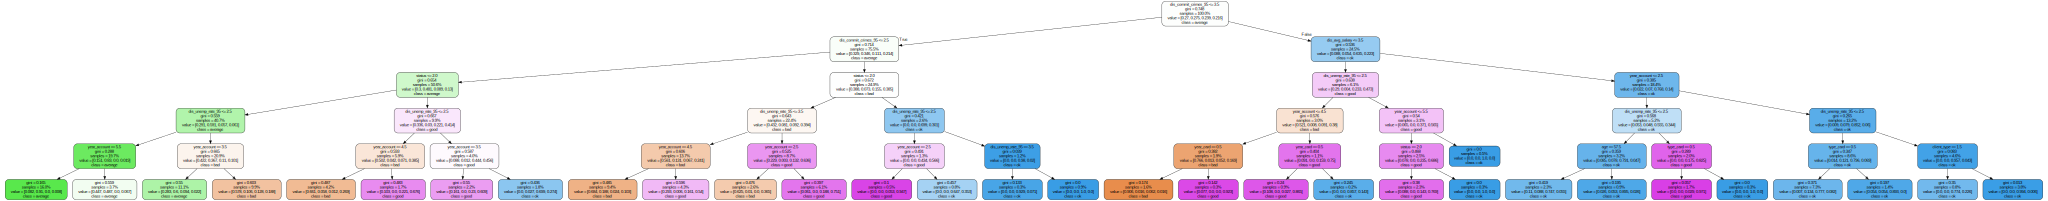

0.702903946389
[[225  86   1  33]
 [ 40 286  24   0]
 [ 23  14 254  57]
 [ 84  11  26 179]]
              precision    recall  f1-score   support

     average       0.60      0.65      0.63       345
         bad       0.72      0.82      0.77       350
        good       0.83      0.73      0.78       348
          ok       0.67      0.60      0.63       300

   micro avg       0.70      0.70      0.70      1343
   macro avg       0.71      0.70      0.70      1343
weighted avg       0.71      0.70      0.70      1343



In [43]:
analytics_random_state = 42

y = clients_rating["sum_score_label"]
feature_names = ["gender", "age", "dis_avg_salary", "dis_unemp_rate_95", "dis_unemp_rate_96",
        "dis_commit_crimes_95", "dis_commit_crimes_96", "client_type", "type_card", "year_card", "frequency", 
        "year_account", "status"]
X = clients_rating[feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = analytics_random_state)

dt = DecisionTreeClassifier(random_state = analytics_random_state, max_depth=5)
dt.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                feature_names=feature_names, class_names = sum_score_discrete_labels,
                filled = True, 
                proportion = True,
                special_characters = True,
                rounded = True)
graph1 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph1.write_png('score.png')
Image(graph1.create_png())

graph2 = Source(export_graphviz(dt,
                out_file=None,
                feature_names=feature_names, class_names = sum_score_discrete_labels,
                filled = True, 
                proportion = True, 
                rounded = True))

display(SVG(graph2.pipe(format='svg')))

class_predict = dt.predict(X_test)
print(metrics.accuracy_score(y_test, class_predict))
print(metrics.confusion_matrix(y_test, class_predict))
print(metrics.classification_report(y_test, class_predict))

In [71]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LogisticRegression(solver = 'lbfgs', max_iter=96)
model.fit(X_train_scaled, y_train)

/home/home/andre/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  
/home/home/andre/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=96, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
# use the model to make predictions with the test data
y_pred = model.predict(X_test_scaled)
# how did our model perform?
print('accuracy =', metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

accuracy = 0.744416873449
[[145  26  14   8]
 [  2 203  12   0]
 [ 15  17 163  17]
 [ 23   1  71  89]]
              precision    recall  f1-score   support

     average       0.78      0.75      0.77       193
         bad       0.82      0.94      0.88       217
        good       0.63      0.77      0.69       212
          ok       0.78      0.48      0.60       184

   micro avg       0.74      0.74      0.74       806
   macro avg       0.75      0.73      0.73       806
weighted avg       0.75      0.74      0.74       806



In [79]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1792      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 593,665
Trainable params: 593,665
Non-trainable params: 0
_________________________________________________________________


In [81]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [115]:
print(y_train[1:10])
y_pred_lookup = {'bad': 0, 'average': 0.25, 'ok': 0.5, 'good': 0.75}
y_train_val = [y_pred_lookup[val] for val in y_train]
NN_model.fit(X_train_scaled, y_train_val, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

1117       good
803        good
4337    average
3176         ok
2232         ok
3032        bad
1832         ok
2416        bad
219        good
Name: sum_score_label, dtype: category
Categories (4, object): [bad < average < ok < good]
Train on 3650 samples, validate on 913 samples
Epoch 1/500
3650/3650 [==============================] - 1s 298us/step - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364

Epoch 00001: val_loss improved from 0.04630 to 0.03643, saving model to Weights-001--0.03643.hdf5
Epoch 2/500
3650/3650 [==============================] - 1s 229us/step - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.0344 - val_mean_absolute_error: 0.0344

Epoch 00002: val_loss improved from 0.03643 to 0.03438, saving model to Weights-002--0.03438.hdf5
Epoch 3/500
3650/3650 [==============================] - 1s 235us/step - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366

Epoch 00003:

3650/3650 [==============================] - 1s 244us/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406

Epoch 00036: val_loss did not improve from 0.03438
Epoch 37/500
3650/3650 [==============================] - 1s 225us/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360

Epoch 00037: val_loss did not improve from 0.03438
Epoch 38/500
3650/3650 [==============================] - 1s 230us/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0350 - val_mean_absolute_error: 0.0350

Epoch 00038: val_loss did not improve from 0.03438
Epoch 39/500
3650/3650 [==============================] - 1s 240us/step - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361

Epoch 00039: val_loss did not improve from 0.03438
Epoch 40/500
3650/3650 [==============================] - 1s 282us/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_lo


Epoch 00072: val_loss did not improve from 0.03374
Epoch 73/500
3650/3650 [==============================] - 1s 221us/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365

Epoch 00073: val_loss did not improve from 0.03374
Epoch 74/500
3650/3650 [==============================] - 1s 222us/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357

Epoch 00074: val_loss did not improve from 0.03374
Epoch 75/500
3650/3650 [==============================] - 1s 219us/step - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372

Epoch 00075: val_loss did not improve from 0.03374
Epoch 76/500
3650/3650 [==============================] - 1s 222us/step - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0365 - val_mean_absolute_error: 0.0365

Epoch 00076: val_loss did not improve from 0.03374
Epoch 77/500
3650/3650 [==============================] - 1s


Epoch 00109: val_loss did not improve from 0.03374
Epoch 110/500
3650/3650 [==============================] - 1s 238us/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0388 - val_mean_absolute_error: 0.0388

Epoch 00110: val_loss did not improve from 0.03374
Epoch 111/500
3650/3650 [==============================] - 1s 230us/step - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0384 - val_mean_absolute_error: 0.0384

Epoch 00111: val_loss did not improve from 0.03374
Epoch 112/500
3650/3650 [==============================] - 1s 235us/step - loss: 0.0233 - mean_absolute_error: 0.0233 - val_loss: 0.0360 - val_mean_absolute_error: 0.0360

Epoch 00112: val_loss did not improve from 0.03374
Epoch 113/500
3650/3650 [==============================] - 1s 238us/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363

Epoch 00113: val_loss did not improve from 0.03374
Epoch 114/500
3650/3650 [==============================]


Epoch 00146: val_loss did not improve from 0.03374
Epoch 147/500
3650/3650 [==============================] - 1s 235us/step - loss: 0.0224 - mean_absolute_error: 0.0224 - val_loss: 0.0362 - val_mean_absolute_error: 0.0362

Epoch 00147: val_loss did not improve from 0.03374
Epoch 148/500
3650/3650 [==============================] - 1s 224us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377

Epoch 00148: val_loss did not improve from 0.03374
Epoch 149/500
3650/3650 [==============================] - 1s 228us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0369 - val_mean_absolute_error: 0.0369

Epoch 00149: val_loss did not improve from 0.03374
Epoch 150/500
3650/3650 [==============================] - 1s 233us/step - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0379 - val_mean_absolute_error: 0.0379

Epoch 00150: val_loss did not improve from 0.03374
Epoch 151/500
3650/3650 [==============================]


Epoch 00183: val_loss did not improve from 0.03374
Epoch 184/500
3650/3650 [==============================] - 1s 236us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0367 - val_mean_absolute_error: 0.0367

Epoch 00184: val_loss did not improve from 0.03374
Epoch 185/500
3650/3650 [==============================] - 1s 239us/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359

Epoch 00185: val_loss did not improve from 0.03374
Epoch 186/500
3650/3650 [==============================] - 1s 229us/step - loss: 0.0231 - mean_absolute_error: 0.0231 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352

Epoch 00186: val_loss did not improve from 0.03374
Epoch 187/500
3650/3650 [==============================] - 1s 266us/step - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366

Epoch 00187: val_loss did not improve from 0.03374
Epoch 188/500
3650/3650 [==============================]


Epoch 00220: val_loss did not improve from 0.03374
Epoch 221/500
3650/3650 [==============================] - 1s 246us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352

Epoch 00221: val_loss did not improve from 0.03374
Epoch 222/500
3650/3650 [==============================] - 1s 221us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363

Epoch 00222: val_loss did not improve from 0.03374
Epoch 223/500
3650/3650 [==============================] - 1s 225us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403

Epoch 00223: val_loss did not improve from 0.03374
Epoch 224/500
3650/3650 [==============================] - 1s 223us/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0363 - val_mean_absolute_error: 0.0363

Epoch 00224: val_loss did not improve from 0.03374
Epoch 225/500
3650/3650 [==============================]


Epoch 00257: val_loss did not improve from 0.03374
Epoch 258/500
3650/3650 [==============================] - 1s 220us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349

Epoch 00258: val_loss did not improve from 0.03374
Epoch 259/500
3650/3650 [==============================] - 1s 224us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361

Epoch 00259: val_loss did not improve from 0.03374
Epoch 260/500
3650/3650 [==============================] - 1s 214us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357

Epoch 00260: val_loss did not improve from 0.03374
Epoch 261/500
3650/3650 [==============================] - 1s 243us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0348 - val_mean_absolute_error: 0.0348

Epoch 00261: val_loss did not improve from 0.03374
Epoch 262/500
3650/3650 [==============================]


Epoch 00294: val_loss did not improve from 0.03374
Epoch 295/500
3650/3650 [==============================] - 1s 253us/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374

Epoch 00295: val_loss did not improve from 0.03374
Epoch 296/500
3650/3650 [==============================] - 1s 273us/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0391 - val_mean_absolute_error: 0.0391

Epoch 00296: val_loss did not improve from 0.03374
Epoch 297/500
3650/3650 [==============================] - 1s 258us/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0399 - val_mean_absolute_error: 0.0399

Epoch 00297: val_loss did not improve from 0.03374
Epoch 298/500
3650/3650 [==============================] - 1s 258us/step - loss: 0.0231 - mean_absolute_error: 0.0231 - val_loss: 0.0368 - val_mean_absolute_error: 0.0368

Epoch 00298: val_loss did not improve from 0.03374
Epoch 299/500
3650/3650 [==============================]

3650/3650 [==============================] - 1s 247us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359

Epoch 00331: val_loss did not improve from 0.03289
Epoch 332/500
3650/3650 [==============================] - 1s 244us/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0335 - val_mean_absolute_error: 0.0335

Epoch 00332: val_loss did not improve from 0.03289
Epoch 333/500
3650/3650 [==============================] - 1s 251us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0351 - val_mean_absolute_error: 0.0351

Epoch 00333: val_loss did not improve from 0.03289
Epoch 334/500
3650/3650 [==============================] - 1s 258us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355

Epoch 00334: val_loss did not improve from 0.03289
Epoch 335/500
3650/3650 [==============================] - 1s 267us/step - loss: 0.0221 - mean_absolute_error: 0.0221 - va

3650/3650 [==============================] - 1s 226us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376

Epoch 00368: val_loss did not improve from 0.03289
Epoch 369/500
3650/3650 [==============================] - 1s 222us/step - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355

Epoch 00369: val_loss did not improve from 0.03289
Epoch 370/500
3650/3650 [==============================] - 1s 223us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0366 - val_mean_absolute_error: 0.0366

Epoch 00370: val_loss did not improve from 0.03289
Epoch 371/500
3650/3650 [==============================] - 1s 218us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371

Epoch 00371: val_loss did not improve from 0.03289
Epoch 372/500
3650/3650 [==============================] - 1s 234us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - va

3650/3650 [==============================] - 1s 245us/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358

Epoch 00405: val_loss did not improve from 0.03289
Epoch 406/500
3650/3650 [==============================] - 1s 249us/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0356 - val_mean_absolute_error: 0.0356

Epoch 00406: val_loss did not improve from 0.03289
Epoch 407/500
3650/3650 [==============================] - 1s 237us/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341

Epoch 00407: val_loss did not improve from 0.03289
Epoch 408/500
3650/3650 [==============================] - 1s 227us/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342

Epoch 00408: val_loss did not improve from 0.03289
Epoch 409/500
3650/3650 [==============================] - 1s 224us/step - loss: 0.0200 - mean_absolute_error: 0.0200 - va

3650/3650 [==============================] - 1s 242us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375

Epoch 00442: val_loss did not improve from 0.03289
Epoch 443/500
3650/3650 [==============================] - 1s 225us/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346

Epoch 00443: val_loss did not improve from 0.03289
Epoch 444/500
3650/3650 [==============================] - 1s 281us/step - loss: 0.0222 - mean_absolute_error: 0.0222 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364

Epoch 00444: val_loss did not improve from 0.03289
Epoch 445/500
3650/3650 [==============================] - 1s 265us/step - loss: 0.0223 - mean_absolute_error: 0.0223 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353

Epoch 00445: val_loss did not improve from 0.03289
Epoch 446/500
3650/3650 [==============================] - 1s 255us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - va

3650/3650 [==============================] - 1s 233us/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377

Epoch 00479: val_loss did not improve from 0.03289
Epoch 480/500
3650/3650 [==============================] - 1s 244us/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349

Epoch 00480: val_loss did not improve from 0.03289
Epoch 481/500
3650/3650 [==============================] - 1s 241us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355

Epoch 00481: val_loss did not improve from 0.03289
Epoch 482/500
3650/3650 [==============================] - 1s 228us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355

Epoch 00482: val_loss did not improve from 0.03289
Epoch 483/500
3650/3650 [==============================] - 1s 218us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - va

In [116]:
# Load wights file of the best model :
wights_file = 'Weights-489--0.03281.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
predictions = NN_model.predict(X_test_scaled)

In [137]:
def score_to_class(score):
    if score <= 0.05:
        return 'bad'
    elif score <= 0.3:
        return 'average'
    elif score <= 0.54:
        return 'ok'
    else:
        return 'good'

y_pred = np.array([score_to_class(pred) for pred in predictions])
print('accuracy =', metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

accuracy = 0.899503722084
[[185   2   3   3]
 [  2 194  18   3]
 [ 11   2 184  15]
 [  5   0  17 162]]
              precision    recall  f1-score   support

     average       0.91      0.96      0.93       193
         bad       0.98      0.89      0.93       217
        good       0.83      0.87      0.85       212
          ok       0.89      0.88      0.88       184

   micro avg       0.90      0.90      0.90       806
   macro avg       0.90      0.90      0.90       806
weighted avg       0.90      0.90      0.90       806

